# Homework2

## Preprocessing

In [1]:
# Import some useful libraries
import pandas as pd
import seaborn as sns
import numpy as np
import random
import re
import os
from math import pi

SAMPLE_SIZE = 1000000

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
!pip install pyarrow

You should consider upgrading via the 'C:\Users\carol\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip' command.


In [3]:
class Dataset:
    def __init__(self, file:str):
        self.file_name : str = file
        self.types : dict = self.load_types()
        self.df : pd.DataFrame = None
        
    def name(self):
        return re.search(r'\/([\w\d]*)\.csv',self.file_name).group(1)
    
    def __types_file__(self):
        return 'types/' + self.name() +'.npy'
        
    def save_types(self):
        np.save(self.__types_file__(), self.types)
        
    def load_types(self):
        if os.path.isfile(self.__types_file__()):
            self.types = np.load(self.__types_file__(),allow_pickle='TRUE').item()
            return self.types
        return None
    
    def col(self,columns:list, index:bool=True,**pd_params)->pd.DataFrame:
        """Loads some columns of the dataframe out of the whole csv file
        
        :param columns: a list of the desired columns
        :type columns: list
        :param index: if True loads also the 'sid' column as the index
        :type index: bool
        :param **pd_params: any other params for pd.read_csv(...)
        :rtype: pd.DataFrame
        """
        col_list = columns
        if 'cts' in col_list:
            pd_params['parse_dates'] = ['cts']
        if index :
            col_list.append('sid')
        return pd.read_csv(self.file_name,
                           usecols=col_list,
                           dtype=self.types, 
                           index_col='sid' if index else None,
                           delimiter='\t', 
                           **pd_params)

datasets = [
    Dataset(file='instagram-dataset/instagram_profiles.csv'), 
    Dataset(file='instagram-dataset/instagram_locations.csv'), 
    Dataset(file='instagram-dataset/instagram_posts.csv')
]
profiles, locations, posts = datasets

In [4]:
profiles.types = {
#     'sid' : 'Int64',
    'profile_id' : 'Int64',
    'profile_name' : pd.StringDtype(storage='pyarrow'),
    'firstname_lastname' : pd.StringDtype(storage='pyarrow'),
    'description' : pd.StringDtype(storage='pyarrow'),
    'following' : 'Int64',
    'followers' : 'Int64',
    'n_posts' : 'Int64',
    'url' : pd.StringDtype(storage='pyarrow'),
#     'cts' : pd.DatetimeTZDtype(tz='UTC'), #obtained through parse_dates=['cts']
    'is_business_account' : pd.BooleanDtype()
}
posts.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'sid_profile' : 'Int64',
    'post_id' : pd.StringDtype(storage='pyarrow'),
    'profile_id' : 'Int64',
    'location_id' : 'Int64',
    'description' : pd.StringDtype(storage='pyarrow'),
    'post_type' : pd.CategoricalDtype(categories=[1,2,3]),
    'numbr_likes' : 'Int64',
    'number_comments' : 'Int64'
}
locations.types = {
#     'sid' : 'Int64', # gives an error, maybe because it's the index?
    'id' : 'Int64',
    'name' : pd.StringDtype(storage='pyarrow'),
    'street' : pd.StringDtype(storage='pyarrow'),
    'zip' : pd.StringDtype(storage='pyarrow'),
    'city' : pd.StringDtype(storage='pyarrow'),
    'region' : pd.StringDtype(storage='pyarrow'),
    'cd' : pd.CategoricalDtype(),
    'phone' : pd.StringDtype(storage='pyarrow'),
    'aj_exact_city_match' : pd.BooleanDtype(),
    'aj_exact_country_match' : pd.BooleanDtype(),
    'blurb' : pd.StringDtype(storage='pyarrow'),
    'dir_city_id' : pd.StringDtype(storage='pyarrow'),
    'dir_city_name' : pd.StringDtype(storage='pyarrow'),
    'dir_city_slug' : pd.StringDtype(storage='pyarrow'),
    'dir_country_id' : pd.CategoricalDtype(),
    'dir_country_name' : pd.CategoricalDtype(),
    'lat' : pd.Float32Dtype(),
    'lng' : pd.Float32Dtype(),
    'primary_alias_on_fb' : pd.StringDtype(storage='pyarrow'),
    'slug' : pd.StringDtype(storage='pyarrow'),
    'website' : pd.StringDtype(storage='pyarrow'),
}

In [5]:
def get_types(signed=True, unsigned=True, custom=[]):
    '''Returns a pandas dataframe containing the boundaries of each integer dtype'''
    # based on https://stackoverflow.com/a/57894540/9419492
    pd_types = custom
    if signed:
        pd_types += [pd.Int8Dtype() ,pd.Int16Dtype() ,pd.Int32Dtype(), pd.Int64Dtype()]
    if unsigned:
        pd_types += [pd.UInt8Dtype() ,pd.UInt16Dtype(), pd.UInt32Dtype(), pd.UInt64Dtype()]
    type_df = pd.DataFrame(data=pd_types, columns=['pd_type'])
    type_df['np_type'] = type_df['pd_type'].apply(lambda t: t.numpy_dtype)
    type_df['min_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).min)
    type_df['max_value'] = type_df['np_type'].apply(lambda row: np.iinfo(row).max)
    type_df['allow_negatives'] = type_df['min_value'] < 0
    type_df['size'] = type_df['np_type'].apply(lambda row: row.itemsize)
    type_df.sort_values(by=['size', 'allow_negatives'], inplace=True)
    return type_df.reset_index(drop=True)
def downcast_int(file_path, column:str, chunksize=10000, delimiter=',', signed=True, unsigned=True):
    '''Assigns the smallest possible dtype to an integer column of a csv'''
    types = get_types(signed, unsigned)
    negatives = False
    print(delimiter)
    for chunk in pd.read_csv(file_path, 
                             usecols=[column],
                             delimiter=delimiter,
                             chunksize=chunksize):
        M = chunk[column].max()
        m = chunk[column].min()
        if not signed and not negatives and m < 0 :
            types = types[types['allow_negatives']] # removes unsigned rows
            negatives = True
        if m < types['min_value'].iloc[0]:
            types = types[types['min_value'] < m]
        if M > types['max_value'].iloc[0]:
            types = types[types['max_value'] > M]
        if len(types) == 1:
            print('early stop')
            break
    return types['pd_type'].iloc[0]

def optimize_cols(file, int_cols, delimiter=',', signed=True, unsigned=True):
    out = dict()
    for col in int_cols:
        out[col] = downcast_int(file, col, delimiter=delimiter, signed=signed, unsigned=unsigned)
    return out

In [6]:
for ds in datasets:
    if not ds.load_types():
        int_cols = [k for k,v in ds.types.items() if v == 'Int64']
        print(int_cols)
        ds.types.update(optimize_cols(ds.file_name, int_cols, delimiter='\t'))
        print(f'Optimized {len(int_cols)} types for {ds.name()}')
    ds.save_types()

for ds in datasets:
    ds.df = pd.read_csv(ds.file_name, dtype=ds.types, index_col='sid', delimiter='\t', parse_dates=['cts'], nrows=SAMPLE_SIZE)
    avg_mem_unoptimized = pd.read_csv(ds.file_name, index_col='sid', delimiter='\t', nrows=SAMPLE_SIZE).memory_usage(deep=True).sum()/SAMPLE_SIZE
    avg_mem_optimized = ds.df.memory_usage(deep=True).sum()/SAMPLE_SIZE
    print(f'{ds.name().ljust(19)} mean optimized memory usage per entry:  {round(avg_mem_optimized):3} B vs {round(avg_mem_unoptimized):4} B  : {round(avg_mem_optimized/avg_mem_unoptimized*100,2):5}%') 

instagram_profiles  mean optimized memory usage per entry:  182 B vs  510 B  : 35.69%
instagram_locations mean optimized memory usage per entry:  276 B vs 1128 B  : 24.46%
instagram_posts     mean optimized memory usage per entry:  272 B vs  743 B  : 36.57%


# [RQ2]

### Plot the number of posts for each profile in descending order

In [7]:
d_prof = profiles.col(["profile_name", "n_posts", "following", "followers", "is_business_account"])

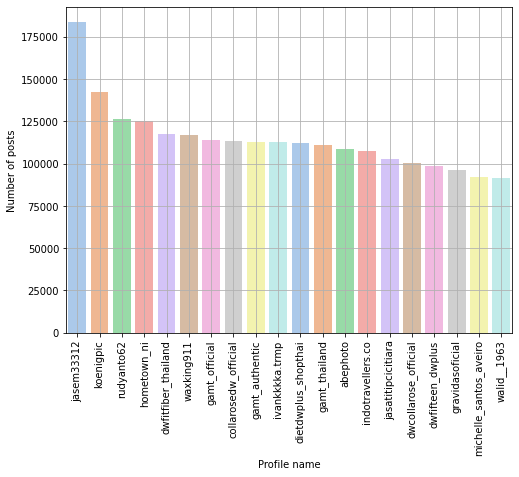

In [8]:
#We limit it to the top 20
plt.rcParams['figure.figsize'] = [8,6]
plot_order = d_prof.sort_values(by=['n_posts'], ascending=False).head(20)
sns.barplot(data=plot_order, x="profile_name", y="n_posts", palette="pastel")
plt.xlabel("Profile name")
plt.xticks(rotation=90)
plt.ylabel("Number of posts")
plt.grid()

### What posts have the highest number of "likes"?

In [9]:
d_posts = posts.col(["profile_id", "location_id", "post_type", "numbr_likes", "number_comments", "post_id"], index=False, nrows=SAMPLE_SIZE)

In [10]:
pop_posts = d_posts.sort_values(by=['numbr_likes'], ascending = False).head(20)
pop_posts

,post_id,profile_id,location_id,post_type,numbr_likes,number_comments
313806,BxrapKyCgg0,4731970969,361936204,1,1963123,53878
918473,BqVfV4VlKRB,191110424,147477665841469,1,1376659,5035
233650,Bld6LughoQ_,1408289748,793182890871330,1,1355678,18733
712304,Bq-INRTlPhO,270902355,766186022,2,1153291,26386
573395,BxbcmE-H9lG,3439002676,392194091,1,1043810,4107
318465,BxXnBYOn7dw,268167552,361081001189541,1,984604,23713
240698,Bkf8aHTAda7,32406002,250228139,2,900232,3401
85047,BZ_YhYugj_s,191110424,256808124805616,1,852230,1491
914815,BnRRq8_htgM,333120168,143063389689916,1,780556,2821
659635,BeECzRuh1O6,25025320,587387369,1,669786,4818


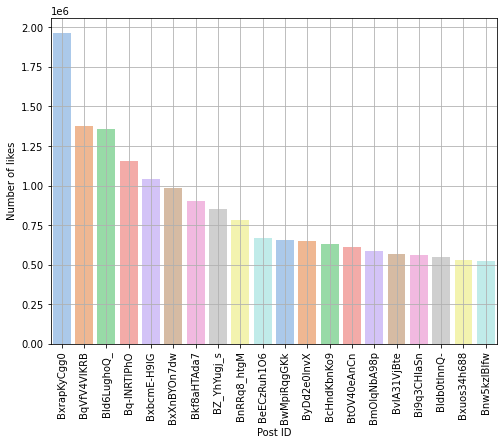

In [11]:
plt.rcParams['figure.figsize'] = [8,6]
plot_order = d_posts.sort_values(by=['numbr_likes'], ascending=False).head(20)
sns.barplot(data=plot_order, x="post_id", y="numbr_likes", palette="pastel")
plt.xlabel("Post ID")
plt.xticks(rotation=90)
plt.ylabel("Number of likes")
plt.grid()

### What posts have the most and the least number of comments?

In [12]:
post_comm = posts.col(["profile_id", "post_type", "number_comments", "post_id"], index=False, nrows=SAMPLE_SIZE)

In [13]:
most_num_comm = post_comm.sort_values(by=['number_comments'], ascending = False).head(10)
most_num_comm

,post_id,profile_id,post_type,number_comments
242837,BQ_N0bzhTSL,55336452,1,135221
579112,BmORc4znzzA,11884528,1,56686
313806,BxrapKyCgg0,4731970969,1,53878
377722,Bbz6IBXhKgg,7396934,1,32505
50077,BuvfTmgFsuY,3950062135,1,31655
712304,Bq-INRTlPhO,270902355,2,26386
318465,BxXnBYOn7dw,268167552,1,23713
940557,BHVg_BkDuxM,553970442,1,20671
304686,Bx-GeASCzBP,44714080,2,20126
233650,Bld6LughoQ_,1408289748,1,18733


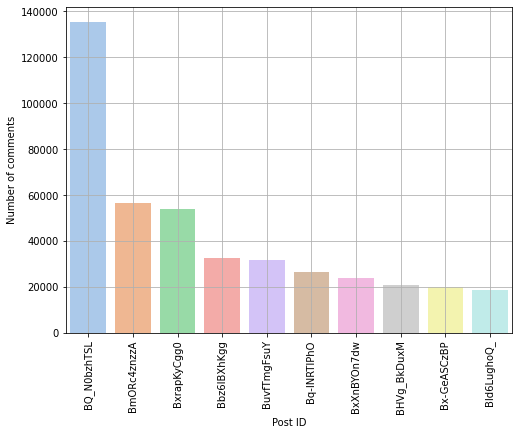

In [14]:
plt.rcParams['figure.figsize'] = [8,6]
sns.barplot(data=most_num_comm, x="post_id", y="number_comments", palette="pastel")
plt.xlabel("Post ID")
plt.xticks(rotation=90)
plt.ylabel("Number of comments")
plt.grid()

In [15]:
most_num_comm.head(1)

,post_id,profile_id,post_type,number_comments
242837,BQ_N0bzhTSL,55336452,1,135221


This is the post with the most number of comments in our chunk of data.

In [16]:
least_num_comm = post_comm.sort_values(by=['number_comments'], ascending = False).tail(10)
least_num_comm

,post_id,profile_id,post_type,number_comments
636320,9YyzFLDT4m,298740846,1,0
636319,-g7LbVJgPO,2274117431,1,0
214343,BvGYPiiB80N,1682486955,1,0
636317,BXYRZNLA3GM,320006468,1,0
636315,BXYcrPBFCw2,2893147210,1,0
214344,BvGXxsCB4D5,1682486955,1,0
636313,BXaXRJeFS03,2893147210,1,0
636312,BXaocqHldI4,2893147210,2,0
636311,BXaovHTFl8y,2893147210,1,0
0,BXdjjUlgcgq,2237947779,2,0


In [17]:
least_num_comm.tail(1)

,post_id,profile_id,post_type,number_comments
0,BXdjjUlgcgq,2237947779,2,0


This is the post with the least number of comments in our chunk of data, but as we can see, there are other posts with 0 comments.

### How many posts include tagged locations, and how many do not? Show it using an appropriate chart and comment your results

In [46]:
#da sistemare, non so bene come raggruppare i post solo per il fatto che hanno taggato una location, e non per location taggate (manca grafico)

In [18]:
d_loc = locations.col(["sid", "id", "name", "city", "cd", "dir_city_name", "dir_city_slug"])

In [19]:
d_loc[["dir_city_slug"]].describe()

,dir_city_slug
count,495221
unique,114426
top,hells-kitchen-manhattan
freq,1326


In [20]:
#divisi per locations
post_loc = d_loc["dir_city_slug"].value_counts(dropna=False)
post_loc

<NA>                       527437
hells-kitchen-manhattan      1326
harlem                       1151
aptekarskiy                  1039
murray-hill-manhattan         933
                            ...  
luzianky                        1
camogli                         1
marinho                         1
south-greenfield                1
gambolovo                       1
Name: dir_city_slug, Length: 114427, dtype: Int64

In [21]:
#solo NA
nan_loc = d_loc["dir_city_slug"].isna().sum()
nan_loc

527437

In [22]:
#solo post con locations
loc_tag = d_loc["dir_city_slug"].value_counts().sum()
loc_tag

495221

### How many posts include only photos? How many also have videos?

In [23]:
post_type = d_posts["post_type"].value_counts() 
post_type

1    940326
2     59671
3         3
Name: post_type, dtype: int64

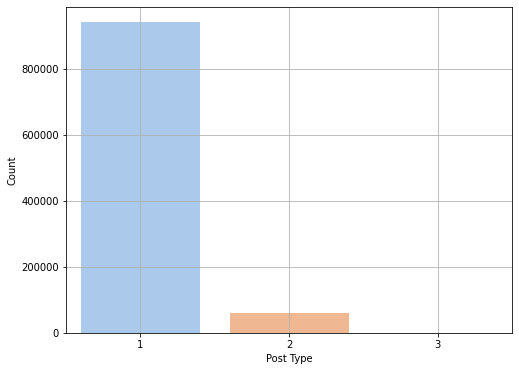

In [24]:
sns.countplot(x=d_posts["post_type"], palette = "pastel")
plt.xlabel("Post Type")
plt.ylabel("Count")
plt.grid()

In this chunk of data there are  94171 posts with only photos and 0 posts with photos and also videos

### What's the percentage of business accounts vs non-business? What can you interpret regarding that percentage?

In [44]:
#da sistemare il grafico, con seaborn viene meglio ma non so come includere gli NA

In [25]:
nan_prof = d_prof["is_business_account"].isna().sum()
nan_prof

1064263

In [26]:
b_prof = d_prof["is_business_account"].value_counts(dropna=False)
b_prof

False    2590069
<NA>     1064263
True      855254
Name: is_business_account, dtype: Int64

<AxesSubplot:>

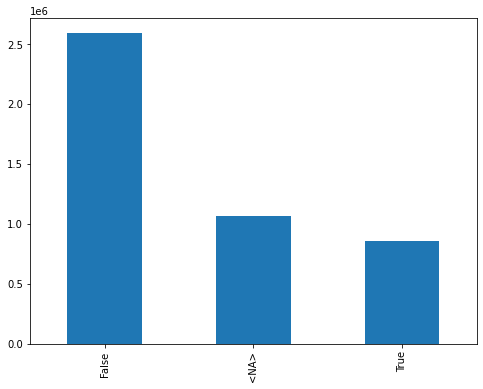

In [27]:
b_prof.plot.bar()

The most profiles are not business accounts, maybe beacause this kind of account is mostly used by influencers or companies, which are a small percentage in the totality of Instagram accounts.

# [RQ5]

### Plot the top 10 most popular users in terms of followers and their number of posts.

In [28]:
users = profiles.col(["profile_name", "profile_id", "followers", "n_posts", "sid"])
pop_users = users.sort_values(by=['followers', 'n_posts'], ascending = False).head(10)
pop_users

,profile_id,profile_name,followers,n_posts
sid,,,,
336492,25025320,instagram,285457645,5760
371414,3416684,victoriassecret,65269440,7355
337097,20824486,nba,35339708,28816
330376,187619120,louisvuitton,30689316,3352
292359,2125506698,buzzfeedtasty,30246783,2791
3437294,496865116,andresiniesta8,29542143,990
158690,23410080,hm,29176804,4566
3615154,24239929,princessyahrini,29042823,4719
508140,50417061,danbilzerian,26476004,1311


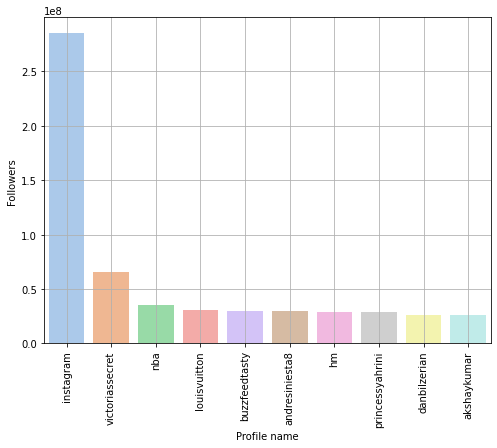

In [29]:
#Plot
plt.rcParams['figure.figsize'] = [8,6]
sns.barplot(data=pop_users, x="profile_name", y="followers", palette="pastel")
plt.xlabel("Profile name")
plt.xticks(rotation=90)
plt.ylabel("Followers")
plt.grid()

### Who is the most influential user?

In [30]:
#forse aggiungerci qualcosa?
pop_users.head(1)

,profile_id,profile_name,followers,n_posts
sid,,,,
336492,25025320,instagram,285457645,5760


The most popular user is Instagram.

### Have they posted anything with tagged locations? Extract the most frequent areas on their posts and plot the number of times each city has been visited.

In [36]:
locations = posts.col(["sid_profile", "location_id", "post_type"], index=False, nrows=SAMPLE_SIZE)

In [47]:
subset = profiles.col(["sid", "profile_name", "followers", "n_posts"])
pop_subset = subset.dropna().nlargest(10, ["followers"])
#pop_subset

In [48]:
#mi da un problema di index con sid

#pop_sid = pop_subset["sid"].tolist()
#ciao = locations.loc[locations['sid_profile'].isin(pop_sid), ['sid_profile', 'location_id']]
#ciao2 = pd.DataFrame(pop_sid)

### How many pictures-only posts have they published? How many reels? (only videos) and how many with both contents? Provide the number as percentages and interpret those figures.

In [41]:
#pop_post_type = locations.loc[locations['sid_profile'].isin(pop_subset['sid']), ['sid_profile', 'post_type']]
#pop_tab = pd.crosstab(pop_post_type['sid_profile'], pop_post_type['post_type'])
#pop_tab

### How many "likes" and comments did posts with only pictures receive? How about videos and mixed posts? Try to provide the average numbers and confront them with their followers amount, explaining what you can say from that comparison.

In [49]:
#groupby su post_type facendo la somma/media di tutti i commenti e like, riportando anche il numero di followers per user 
#users = profiles.col(["profile_name", "profile_id", "followers", "n_posts", ])
#pop_users = users.sort_values(by=['followers', 'n_posts'], ascending = False).head(10)

# [RQ8]

### Does more “likes” also mean more comments? Plot a scatter plot of “likes” vs comments for posts.

In [42]:
posts1 = posts.col(['post_id', 'numbr_likes', 'number_comments'], index=False, nrows=SAMPLE_SIZE)

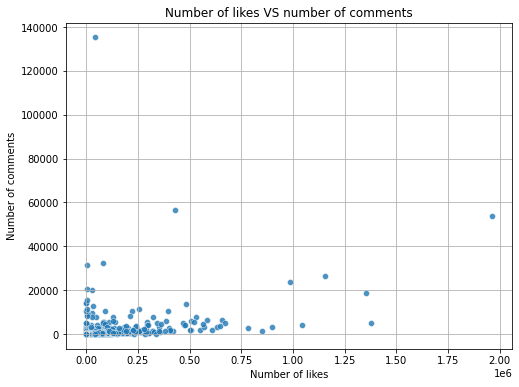

In [43]:
# Let's see graphically with a scatterplot if there is some kind of relationship between the two variables.
#sns.set(rc = {'figure.figsize':(15,8)})
fig = sns.scatterplot(data=posts1, x="numbr_likes", y="number_comments",   
                      alpha=0.8)                               
fig.set(xlabel='Number of likes', ylabel='Number of comments', title='Number of likes VS number of comments')
plt.grid()

It doesn't seem to be a stict correlation between the number of likes and the number of comments. For example there are posts with a lot of likes but only a few comments and vice versa.

### Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice.

### What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures.

### What are histograms, bar plots, scatterplots and pie charts used for?

Histograms, bar plots, scatterplots and pie charts are the most popular and used tools for data visualization.

* **Histograms** are used for representing continuous variables divided into a series of intervals. These intervals must be adjacent and they can be also of different sizes. For each bin (interval) we have a rectangle. If the bins have the same size, the height of the rectangle is proportional to the frequency (the number of cases in each interval), otherwise the *area* of the rectangle has to be proportional to the frequency. In this last case, the height represent the *frequency density* (the number of cases per unit of the variable on the x-axis).

* **Bar plots** are used for comparing categorical data. For each category we have a rectangular bar which heigth is proportional to the value that represents. The bars can be horizontal or vertical.

* **Scatterplots** are plots used for representing values for (usually) two variables in a Cartesian diagram. Every value is represented by a point with coordinates equal to the value for the first variable on the x-axis and the value for the second variable on the y-axis. With a scatterplot we can detect relations and correlations between variables. They can be used for both continuous and discrete variables.

* **Pie charts** are circular statistical graphics. The 'pie' is divided into slices proportional to the quantity it represents. They are suited to express percentage and to observe the composition of a phenomena. The total of the percentages must be equal to 100%. If there are a lot of modalities related to the phenomena we want to represent, it can be worth to use a bar plot, because comparing the area of a lot of 'slices' can be difficult and not so easy.

### What insights can you extract from a Box Plot?

With a **Box Plot** we analyze the distribution of a variable paying attention to its quartiles. In a box plot we can identify the first quartile (as the lower box edge), the median (as the line inside the box) and the third quartile (as the upper box edge). In the box plots can be plotted also lines representing the values located outside lower and upper quartiles. Outlier values can be represented by single points. 

In addition, we are able to know the variability and the dispersion of the variable, looking at the length of the box. If we have a little box, all the data are located near the median, so we have low dispersion; otherwise we have a larger box. We can also get information about the symmetry of a variable, if t